In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4, ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization.training_visualization import plot_grad_flow_hist
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from source.miscellaneous.evaluation import evaluate_model
from einops.einops import rearrange

In [3]:
# torch.autograd.set_detect_anomaly(True)

In [4]:
crop_size = 480
transformation_threshold = 0.3
patch_size = 8
max_translation_shift = 50
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [5]:
from source.datasets.brain_dataset import collate_fn

In [6]:
batch_size = 1

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn,
)

In [7]:
learning_rate = 0.00065
weight_decay = 0.001
use_coarse_context = False
clamp_predictions = True
use_l2_with_standard_deviation = False
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
# block_dimensions_8_2 = [96, 128, 192]
# block_dimensions_16_4 = [64, 96, 128, 192]
block_dimensions = [96, 128, 192]
fine_feature_size = block_dimensions[0]  # 1 for 16_4, 0 for 8_2
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_8_2(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
    clamp_predictions=clamp_predictions,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters()) + list(fine_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [8]:
coarse_loss = "focal"
alpha = 0.25
gamma = 2
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [9]:
seen_datapoints = 0

B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found


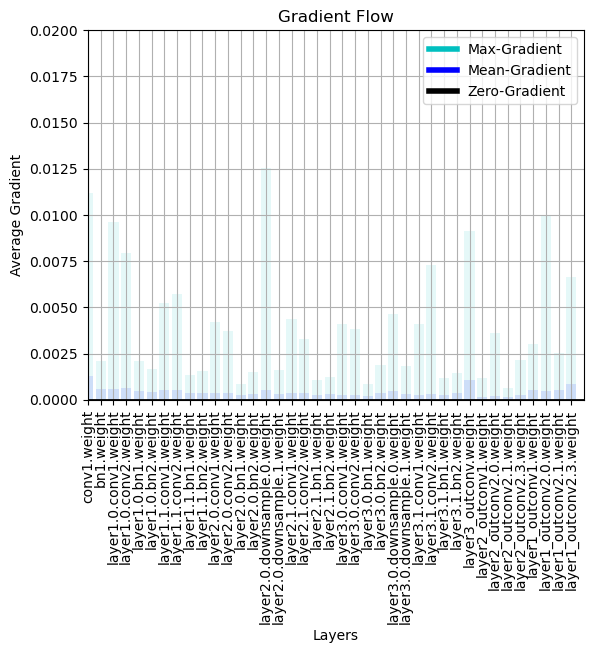

Epoch: 0, Duration: 26.21 sec, Latest Coarse Loss: 3.3121, Latest Fine Loss: 0.7488
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
No matches found
B20_0431_Slice15_transformed.tif B20_

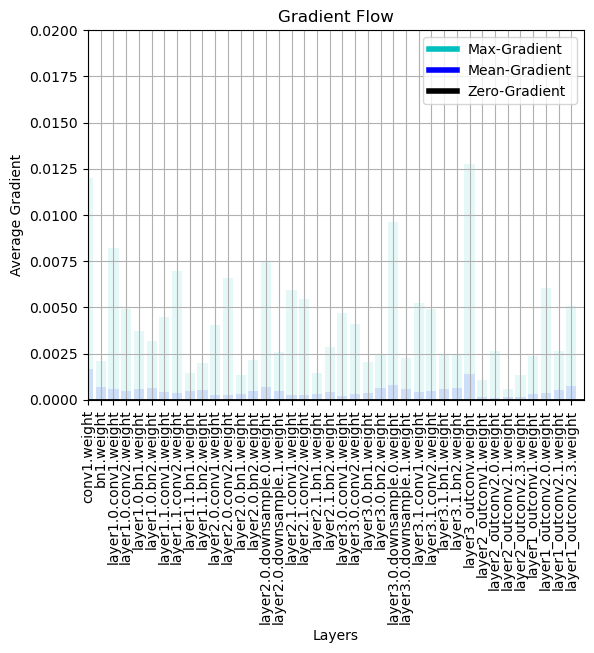

Epoch: 5, Duration: 27.43 sec, Latest Coarse Loss: 2.1188, Latest Fine Loss: 0.6010
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed

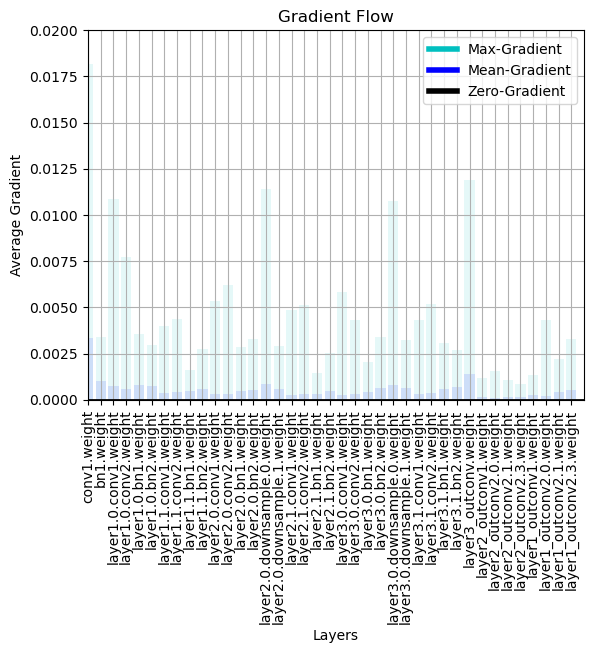

Epoch: 10, Duration: 28.73 sec, Latest Coarse Loss: 2.1176, Latest Fine Loss: 0.5893
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transforme

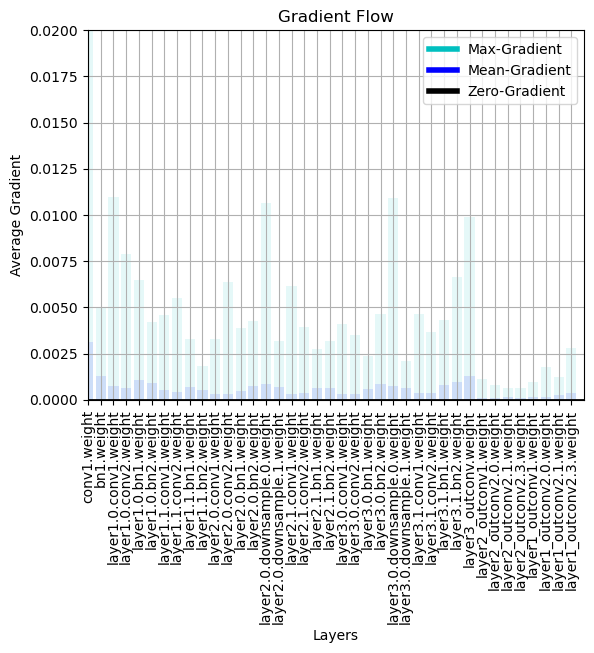

Epoch: 15, Duration: 29.23 sec, Latest Coarse Loss: 2.4235, Latest Fine Loss: 0.5710
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transforme

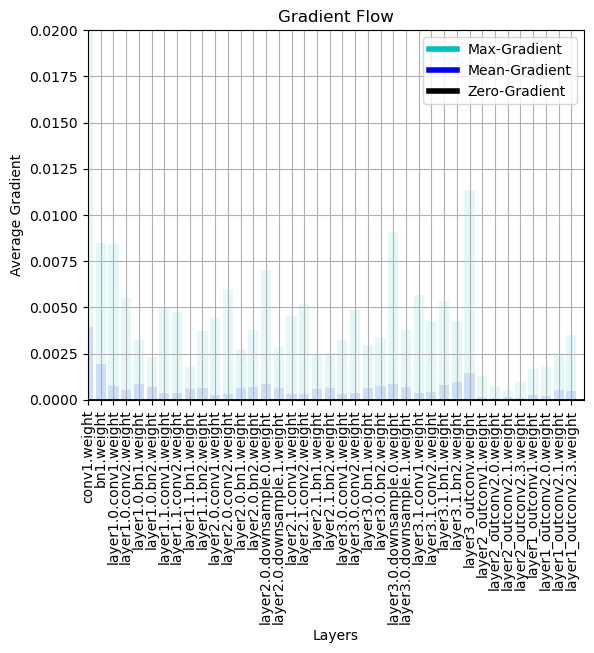

Epoch: 20, Duration: 33.64 sec, Latest Coarse Loss: 1.8866, Latest Fine Loss: 0.5825
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transforme

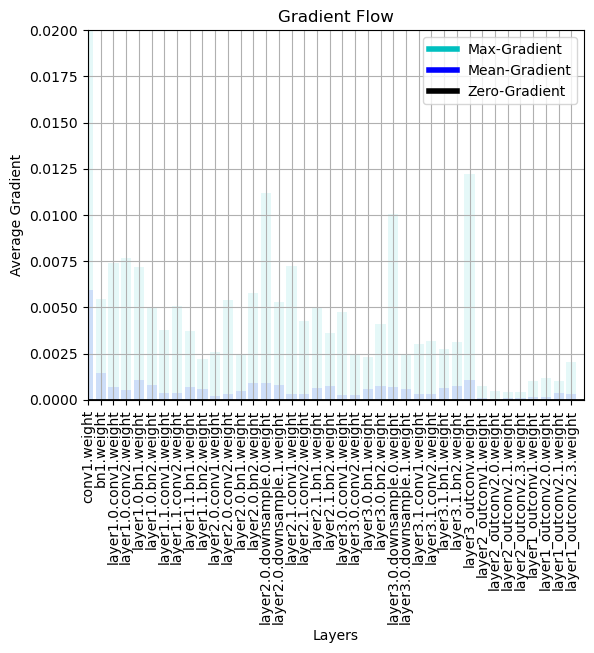

Epoch: 25, Duration: 27.80 sec, Latest Coarse Loss: 1.7431, Latest Fine Loss: 0.5222
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transforme

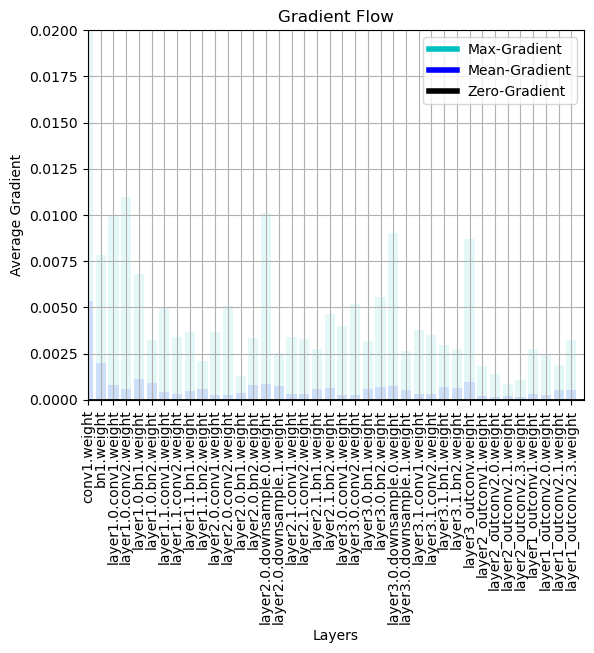

Epoch: 30, Duration: 27.35 sec, Latest Coarse Loss: 1.6157, Latest Fine Loss: 0.5737
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transforme

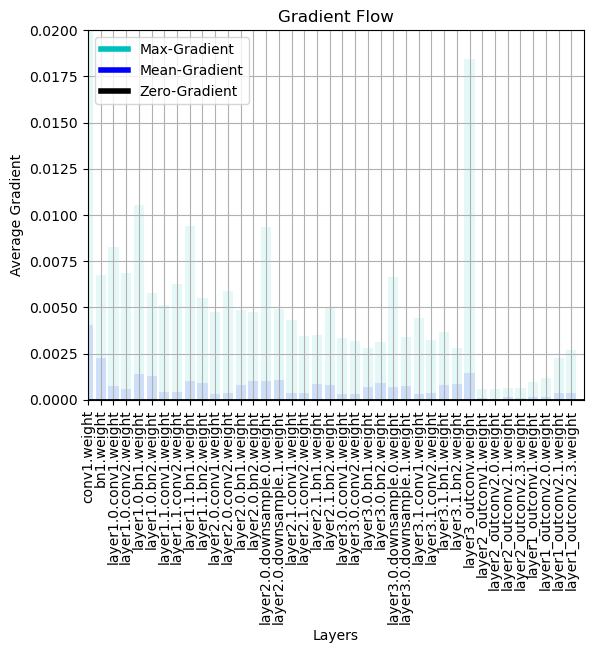

Epoch: 35, Duration: 23.93 sec, Latest Coarse Loss: 1.8694, Latest Fine Loss: 0.5235
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transforme

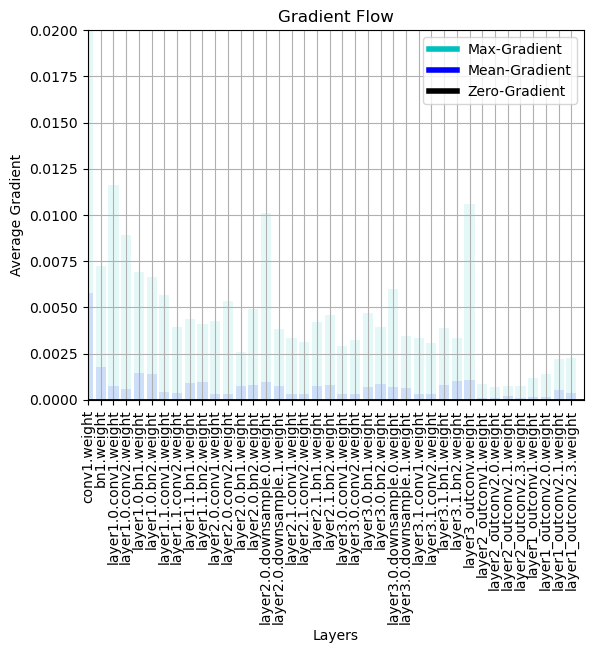

Epoch: 40, Duration: 30.39 sec, Latest Coarse Loss: 1.0415, Latest Fine Loss: 0.4455
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transforme

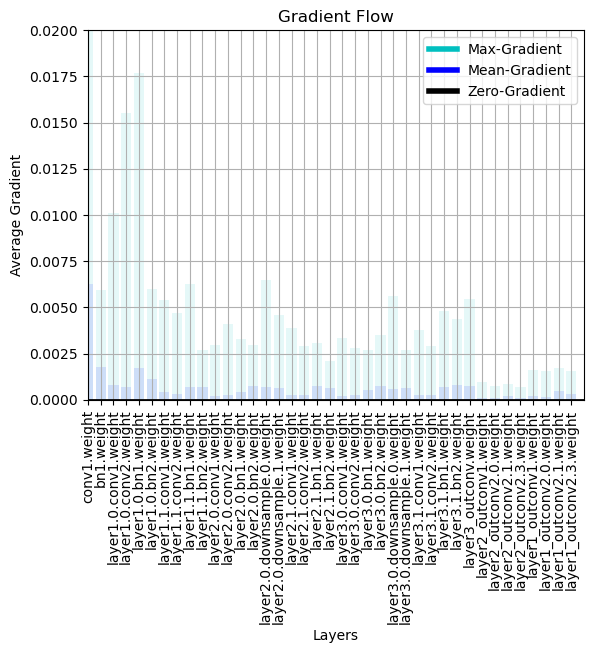

Epoch: 45, Duration: 28.57 sec, Latest Coarse Loss: 1.5480, Latest Fine Loss: 0.5324
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transforme

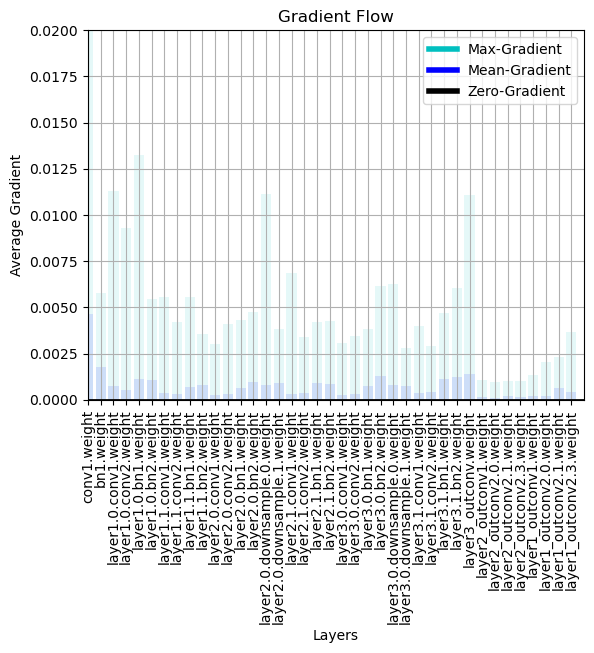

Epoch: 50, Duration: 27.33 sec, Latest Coarse Loss: 1.3733, Latest Fine Loss: 0.4688
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transforme

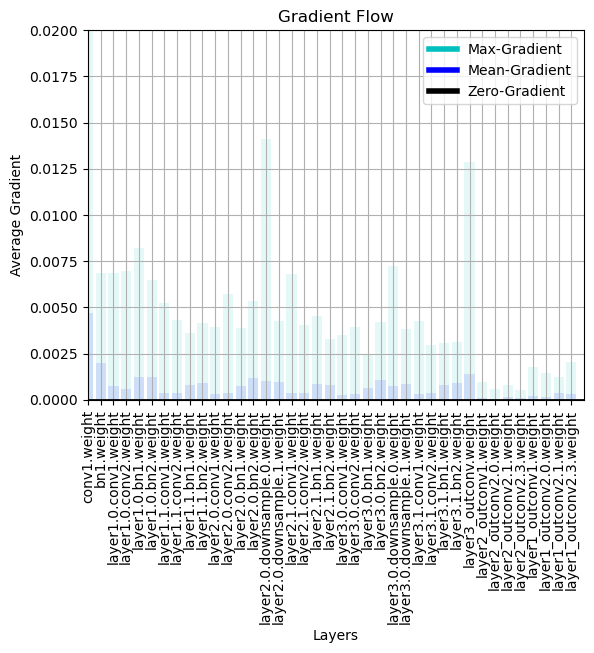

Epoch: 55, Duration: 27.54 sec, Latest Coarse Loss: 1.9129, Latest Fine Loss: 0.5077
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transforme

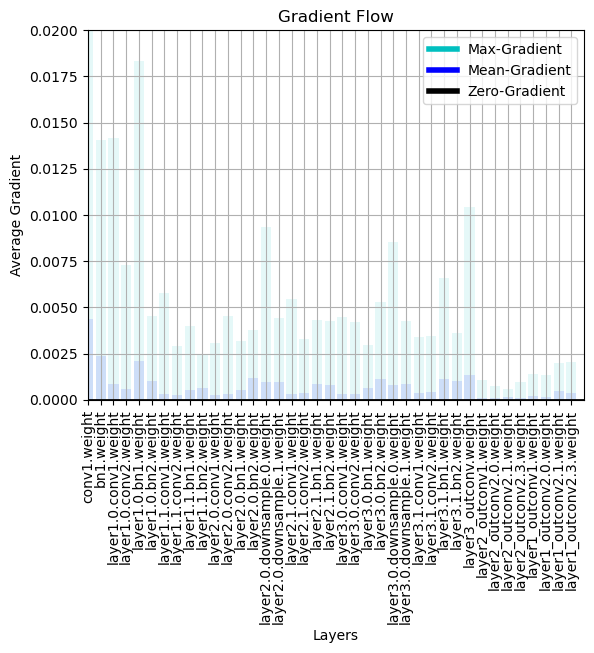

Epoch: 60, Duration: 26.03 sec, Latest Coarse Loss: 1.3609, Latest Fine Loss: 0.4954
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transforme

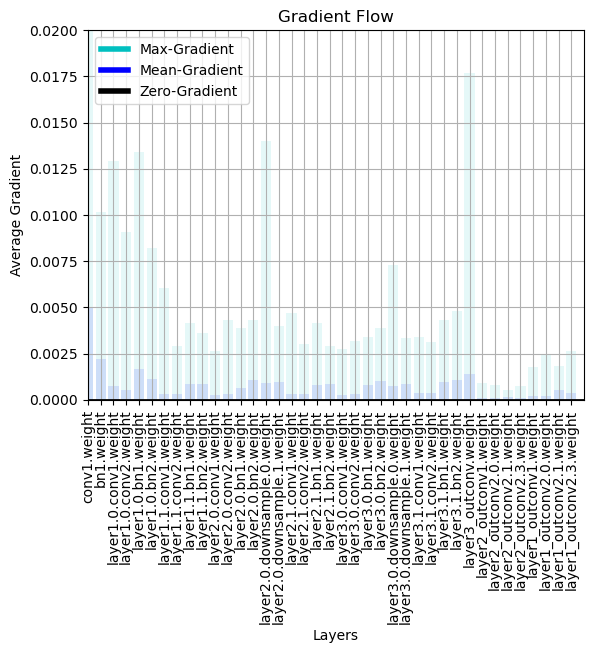

Epoch: 65, Duration: 25.68 sec, Latest Coarse Loss: 1.3878, Latest Fine Loss: 0.4874
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transforme

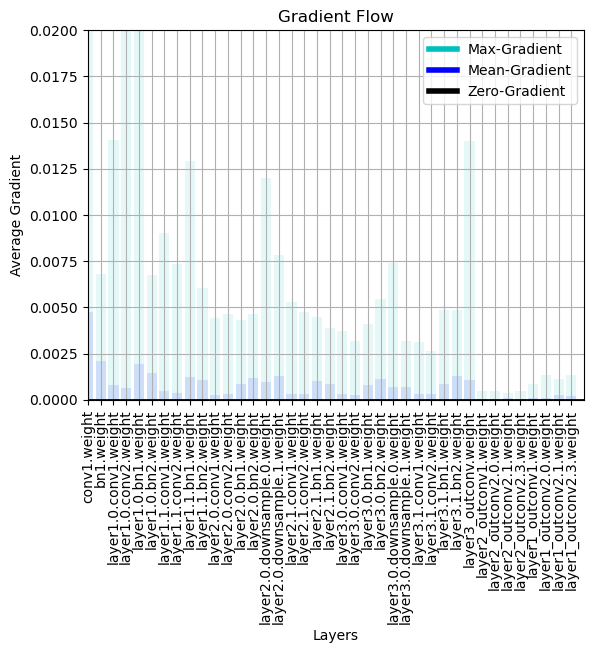

Epoch: 70, Duration: 30.00 sec, Latest Coarse Loss: 1.5375, Latest Fine Loss: 0.4571
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transforme

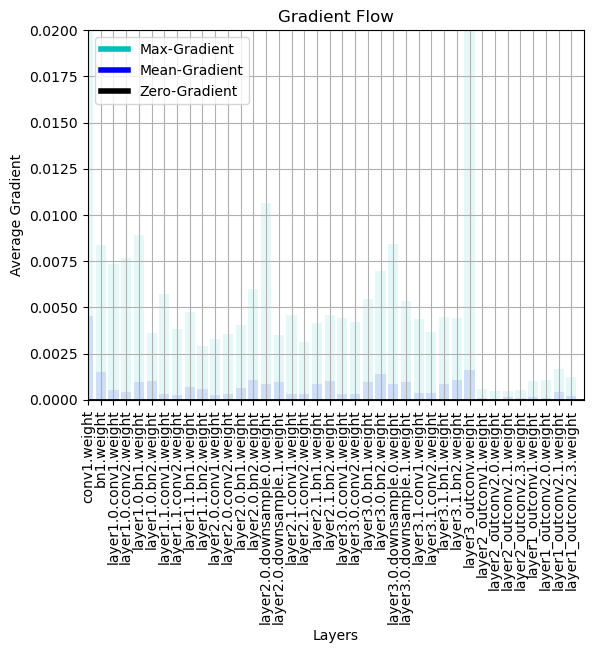

Epoch: 75, Duration: 28.07 sec, Latest Coarse Loss: 1.4692, Latest Fine Loss: 0.4017
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transforme

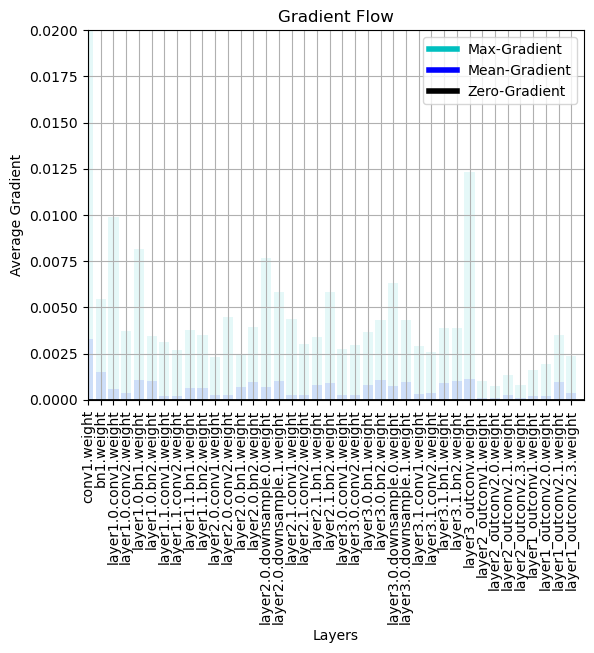

Epoch: 80, Duration: 28.87 sec, Latest Coarse Loss: 0.9991, Latest Fine Loss: 0.4005
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transforme

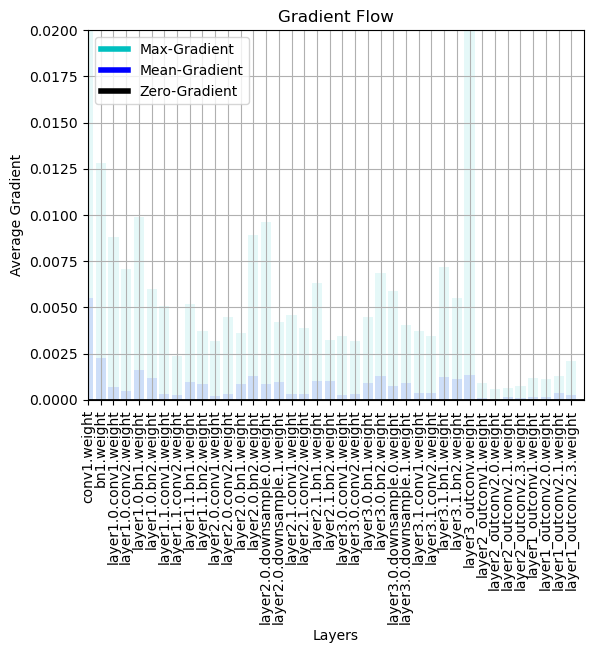

Epoch: 85, Duration: 31.14 sec, Latest Coarse Loss: 1.4467, Latest Fine Loss: 0.4798
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transforme

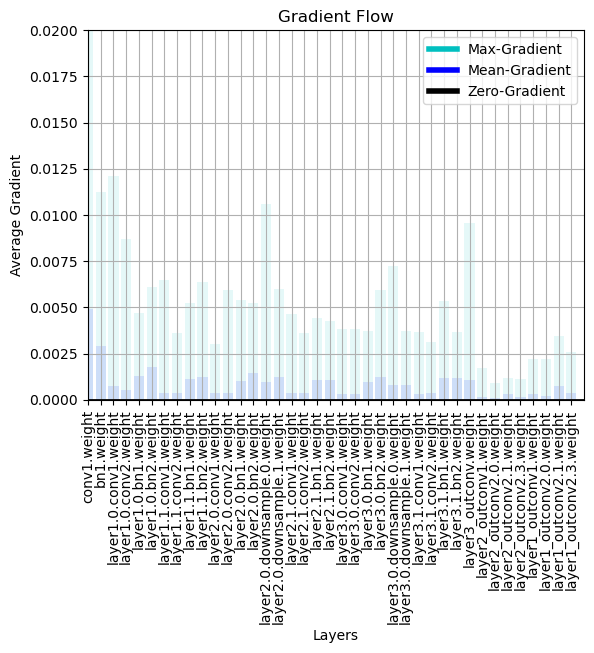

Epoch: 90, Duration: 30.49 sec, Latest Coarse Loss: 1.1268, Latest Fine Loss: 0.5261
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transforme

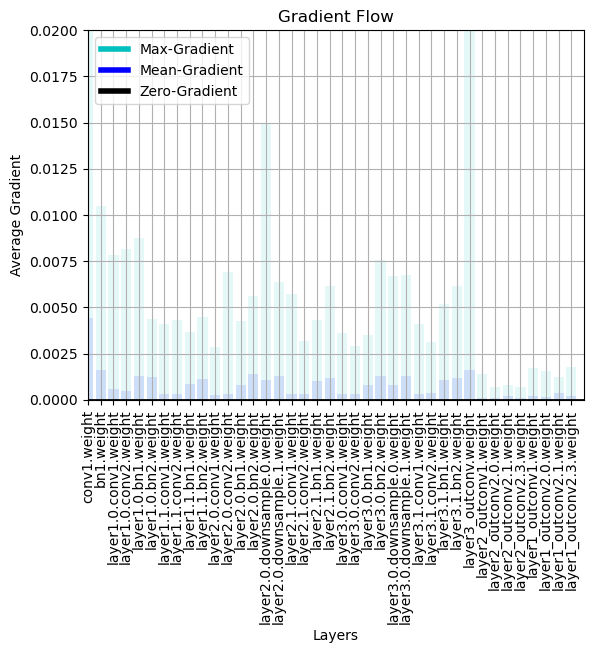

Epoch: 95, Duration: 26.87 sec, Latest Coarse Loss: 2.2000, Latest Fine Loss: 0.5032
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transforme

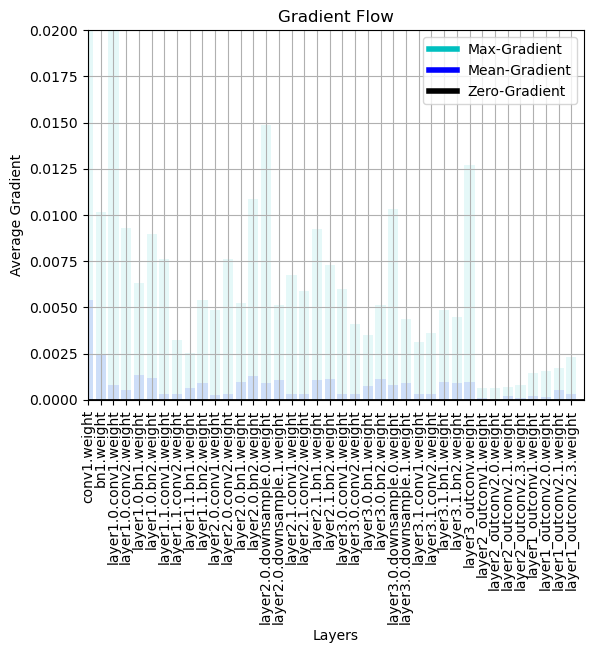

Epoch: 99, Duration: 36.24 sec, Latest Coarse Loss: 1.2514, Latest Fine Loss: 0.4561
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])


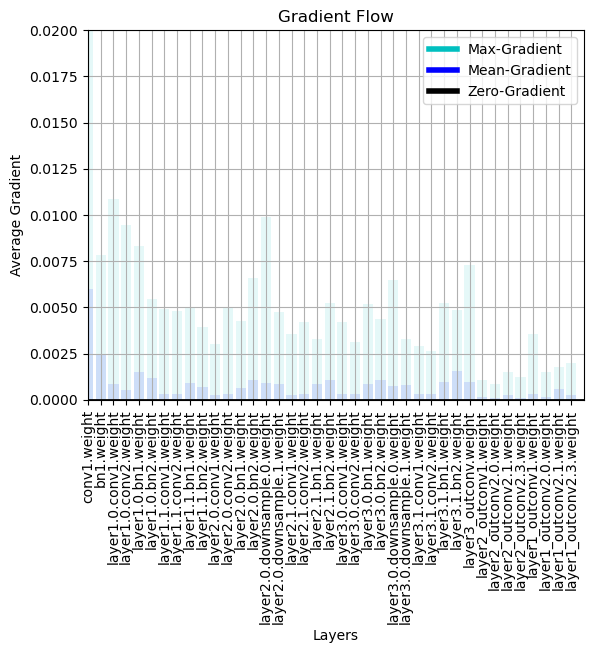

Epoch: 100, Duration: 33.22 sec, Latest Coarse Loss: 1.1368, Latest Fine Loss: 0.4570
B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0432_Slice15_transformed.tif B20_0433_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0434_Slice15_transformed.tif B20_0435_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0435_Slice15_transformed.tif B20_0436_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0433_Slice15_transformed.tif B20_0434_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0430_Slice15_transformed.tif B20_0431_Slice15_transformed.tif
torch.Size([1, 192, 60, 60])
B20_0431_Slice15_transformed.tif B20_0432_Slice15_transform

KeyboardInterrupt: 

In [10]:
print_frequency = 5
epochs = 400

for epoch in range(epochs):
    epoch_start_time = time.time()
    for (
        image_1_crop,
        image_2_crop,
        match_matrix,
        relative_coordinates,
        _,
    ) in dataloader_train:
        seen_datapoints += image_1_crop.shape[0]
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after backbone. Breaking the training.")
            break
        
        print(coarse_image_feature_1.shape)
        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after positional_encoding. Breaking the training.")
            break

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after rearrange. Breaking the training.")
            break

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after coarse_loftr. Breaking the training.")
            break

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        if coarse_matches["confidence_matrix"].isnan().any().item():
            print("coarse_matches['confidence_matrix'] contains NaN values. Breaking the training.")
            break

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2],
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height_width=fine_height_width,
            coarse_height_width=coarse_height_width,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
            )

        if fine_loss == "l2":
            fine_loss_value = fine_l2_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        elif fine_loss == "l2_std":
            fine_loss_value = fine_l2_loss_with_standard_deviation(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        torch.nn.utils.clip_grad_norm_(backbone.parameters(), 1.0)
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())

        if torch.isnan(coarse_matches["confidence_matrix"]).all():
            print(
                "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
            )
            break
    if torch.isnan(coarse_matches["confidence_matrix"]).all():
        print(
            "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
        )
        break

    epoch_duration = time.time() - epoch_start_time
    if epoch % print_frequency == 0 or epoch == (100 - 1):
        plot_grad_flow_hist(backbone.named_parameters())
        print(
            f"Epoch: {epoch}, Duration: {epoch_duration:.2f} sec, Latest Coarse Loss: {coarse_loss_value:.4f}, Latest Fine Loss: {fine_loss_value:.4f}"
        )

In [11]:
seen_datapoints

722

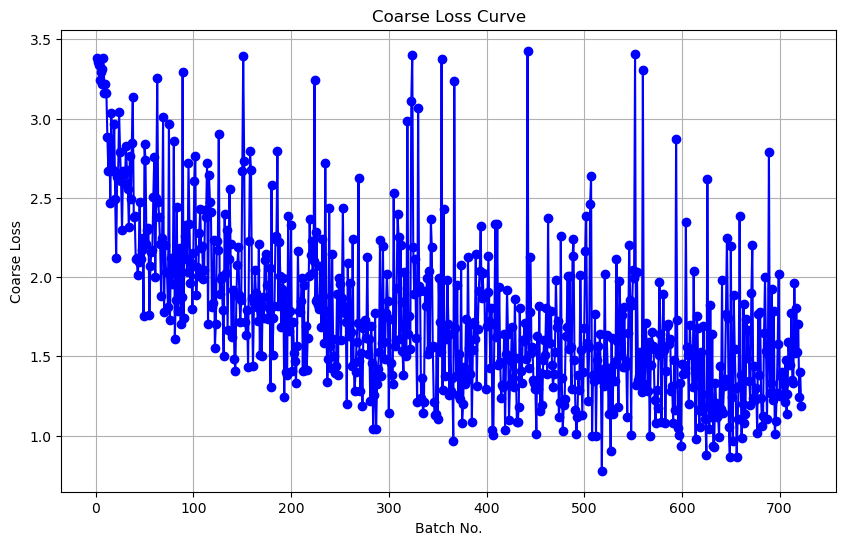

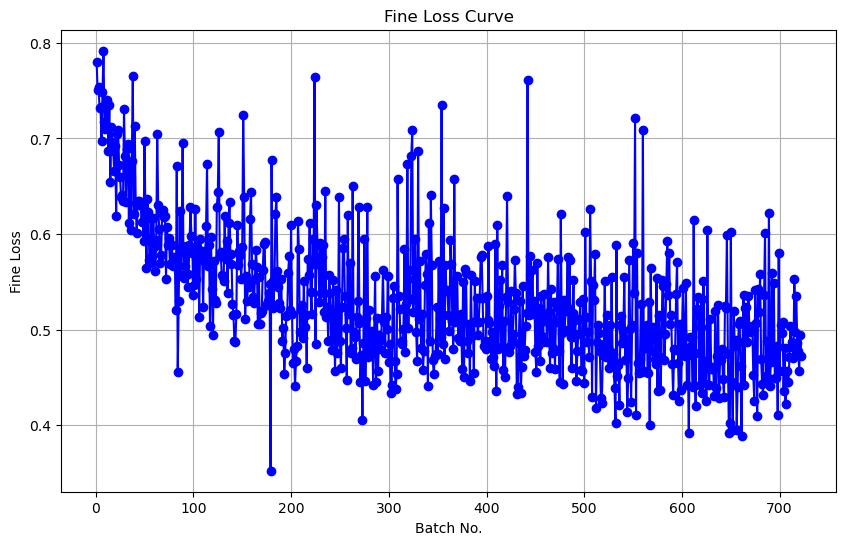

In [12]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")

In [13]:
from source.miscellaneous.model_saving import save_model

In [14]:
hyperparameters = {
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "coarse_context": use_coarse_context,
    "img_size": "3344_3904",
    "ResNet": backbone.__class__.__name__,
    "transform_threshold": transformation_threshold,
    "temperature": temperature,
    "batch_size": batch_size,
    "coarse_loss": coarse_loss,
    "fine_loss": fine_loss,
    "use_train_data": use_train_data,
    "clamp_predictions": clamp_predictions,
    "block_dimensions": block_dimensions,
    "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
    "seen_datapoints": seen_datapoints,
    "crop_size": crop_size
    }

if coarse_loss == "focal":
    hyperparameters["gamma"] = gamma
    hyperparameters["alpha"] = alpha


models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
model_name = save_model(
    models,
    hyperparameters=hyperparameters,
    coarse_loss_history=coarse_loss_history,
    fine_loss_history=fine_loss_history,
)
model_name = model_name.split("/")[-1]

In [3]:
# patch_size=8
# crop_size=480

In [4]:
confidence_threshold = 0.2
block_dimensions = [96, 128, 192]
temperature = 0.2
evaluation_metrics = evaluate_model(
    ["5"], [confidence_threshold], [block_dimensions], [temperature], patch_size=patch_size, crop_size=crop_size
)
evaluation_metrics

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:93: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1


{'5': {'confidence_threshold': 0.2,
  'number_of_matches': 41787,
  'average_distance': 7.729145526885986,
  'auc': 5.163892090942245,
  'entropy': 10.995319366455078,
  'matches_per_patch': [[0.0,
    0.0,
    0.0,
    0.0,
    4.0,
    2.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    5.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0],
   [0.0,
    1.0,
    1.0,
    4.0,
    1.0,
    5.0,
    3.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    2.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    9.0,
    0.0,
    0.0,
    3.0,
    1.0,
    0.0,
    11.0,
    37.0,
    3.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0

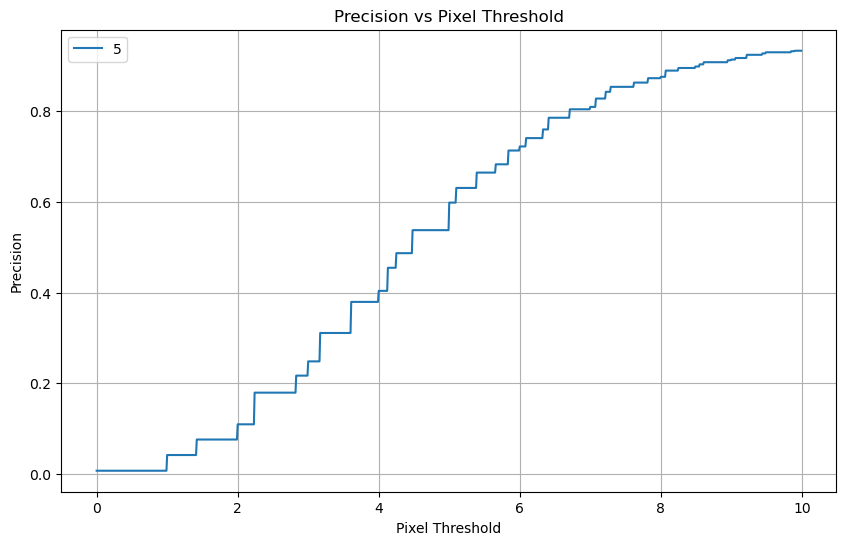

In [6]:
from source.visualization.evaluation_visualization import plot_precision_vs_threshold
plot_precision_vs_threshold(
    evaluation_metrics["5"]["match_precision"],
    labels=["5"],
)